# Machine Learning Fundamentals and Regularization

# Objectives

- Explain the notion of "validation data"
- Use the algorithm of cross-validation (with `sklearn`)
- Explain the concept of regularization
- Use Lasso and Ridge regularization in model design

# When a Good Model Goes Bad

One of the goals of a machine learning project is to make models which are highly predictive.
If the model fails to generalize to unseen data then the model is bad.

Adding complexity to a model can find patterns to help make better predictions! 

But too much complexity can lead to the model finding patterns in the noise...

<img src="images/overfitting_model_meme.jpeg" alt="complex model conspiracy theory meme, image from It's Always Sunny in Philadelphia" width=600>

>So how do we know when our model is ~~a conspiracy theorist~~ overfitting?

## Bias-Variance Tradeoff

1. High bias - **UNDERFITTING**
    1. Systematic error in predictions
    2. Bias is about the strength of assumptions the model makes
    3. Underfit models tend to have high bias
2. High variance - **OVERFITTING**
    1. The model is highly sensitive to changes in the data
    2. Overfit models tend to have low bias

<img src="images/bias_vs_variance.png" width=650>

##### Aside: Example of high bias and variance

High bias is easy to wrap one's mind around: Imagine pulling three red balls from an bucket that has hundreds of balls of all colors in a uniform distribution. Then my sample is a terrible representative of the whole population. If I were to build a model by extrapolating from my sample, that model would predict that _every_ ball produced would be red! That is, this model would be incredibly biased.

High variance is a little bit harder to visualize, but it's basically the "opposite" of this. Imagine that the population of balls in the bucket is mostly red, but also that there are a few balls of other colors floating around. Now imagine that our sample comprises a few balls, none of which is red. In this case, we've essentially picked up on the "noise", rather than the "signal". If I were to build a model by extrapolating from my sample, that model would be needlessly complex. It might predict that balls drawn before noon will be orange and that balls drawn after 8pm will be green, when the reality is that a simple model that predicted 'red' for all balls would be a superior model!

The important idea here is that there is a *trade-off*: If we have too few data in our sample (training set), or too few predictors, we run the risk of high *bias*, i.e. an underfit model. On the other hand, if we have too many predictors (especially ones that are collinear), we run the risk of high *variance*, i.e. an overfit model.

[Here](https://en.wikipedia.org/wiki/Overfitting#/media/File:Overfitting.svg) is a nice illustration of the difficulty.

# How Do We Identify a Bad Model? 🕵️

### Answer: More Complicated Model Validation

Generally speaking we want to take more precautions than using just a test and train split. After all, we're still imagining building just one model on the training set and then crossing our fingers for its performance on the test set.

Data scientists often distinguish *three* subsets of data: **training, validation, and testing**


Roughly:
- Training data is for building the model
- Validation data is for *tweaking* the model
- Testing data is for evaluating the model on unseen data

- Think of **training** data as what you study for a test
- Think of **validation** data is using a practice test (sometimes called the development or dev set)
- Think of **testing** data as the actual test!
    - A **holdout** set is when your test dataset is never used for training (unlike in cross-validation)


<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width=600>

> Image from Scikit-Learn: https://scikit-learn.org/stable/modules/cross_validation.html

### Steps:

1. Split data into training data and a holdout test
2. Design a model
3. Evaluate how well it generalizes with **cross-validation** (only training data)
4. Determine if we should adjust model, use cross-validation to evaluate, and repeat
    - 'Adjusting' model here means things like changing what features, building/engineering new features, but also adjusting _hyperparameters_
5. After iteratively adjusting your model, do a _final_ evaluation with the holdout test set
6. THEN DON'T TOUCH THE MODEL!!!

**Question**: What's different about this procedure from what we've described before? Aren't I just calling the test data "validation data" now? Is there any substantive difference?

- 


### From Validation to Cross-Validation

Since my model will "see" the validation data in any case, I might as well use *all* of my training data to validate my model! How do I do this?

Cross-validation works like this: First I'll partition my training data into $k$-many *folds*. Then I'll train a model on $k-1$ of those folds and "test" it on the remaining fold. I'll do this for all possible divisions of my $k$ folds into $k-1$ training folds and a single "testing" fold. Since there are $k\choose 1$$=k$-many ways of doing this, I'll be building $k$-many models!

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

##### Python Example

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
birds = sns.load_dataset('penguins')
# Renaming columns in case anyone has the old version of the dataset with 'culmen'
birds.columns = ['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex']
birds.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
304,Gentoo,Biscoe,44.9,13.8,212.0,4750.0,Female
180,Chinstrap,Dream,46.4,17.8,191.0,3700.0,Female
160,Chinstrap,Dream,46.0,18.9,195.0,4150.0,Female
165,Chinstrap,Dream,52.0,18.1,201.0,4050.0,Male
85,Adelie,Dream,41.3,20.3,194.0,3550.0,Male


In [3]:
birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
# For simplicity's sake we'll limit our analysis to the numeric columns.
df = birds[['bill_length_mm', 'bill_depth_mm',
                 'flipper_length_mm', 'body_mass_g']]

In [5]:
# We'll drop the rows with null values
df = df.dropna().reset_index()

Suppose I want to model `body_mass_g` as a function of the other attributes.

In [7]:
# Create our X and y
X = df.drop(columns='body_mass_g')
y = df['body_mass_g']

We'll make ten models and record our evaluations of them.

In [8]:
# Instantiate (but no need to fit yet!) a Linear Regression model
lr = LinearRegression()

In [9]:
# Use cross_validate to model 10 different times, across 10 different folds
# Explore the arguments - might set different scoring, or return train scores
cv_results = cross_validate(lr,
                            X,
                            y,
                            cv = 10,
                           return_train_score=True)

In [10]:
# Explore our results
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

In [13]:
cv_results['train_score']

array([0.78273743, 0.77180478, 0.7770143 , 0.77408458, 0.77179887,
       0.7809426 , 0.77169732, 0.75002225, 0.73338377, 0.74245472])

In [14]:
print(f"Avg Train R2: {cv_results['train_score'].mean():.4f} +/- {cv_results['train_score'].std():.4f}")

Avg Train R2: 0.7656 +/- 0.0163


In [15]:
print(f"Avg Validation R2: {cv_results['test_score'].mean():.4f} +/- {cv_results['test_score'].std():.4f}")

Avg Validation R2: 0.1788 +/- 0.3591


#### Evaluate:

- train score is good but test is not


But now what? How can we fix that?

# Preventing Overfitting - Regularization

Again, complex models are very flexible in the patterns that they can model but this also means that they can easily find patterns that are simply statistical flukes of one particular dataset rather than patterns reflective of the underlying process or trend we're trying to model.

When a model has large weights (coefficients), the model is "too confident". This translates to a model with high variance - which puts it in danger of overfitting!

We can combat overfitting/high variance with regularization.

### Some Types of Regularization:

1. Reducing the number of features
2. Increasing the amount of data
3. Penalizing coefficients: Ridge, Lasso, Elastic Net
        

## The Strategy Behind Ridge / LASSO / Elastic Net

Regularization is about introducing a factor into our model designed to enforce the stricture that the coefficients stay small, by _penalizing_ the ones that get too large.

Ridge and LASSO (or the combination of the two, called Elastic Net) regression are examples of **penalized** estimation. Penalized estimation makes some or all of the coefficients smaller in magnitude (closer to zero). Some of the penalties have the property of performing both variable selection (setting some coefficients exactly equal to zero) and shrinking the other coefficients. 


### LASSO (Least Absolute Shrinkage and Selection Operator): L1 Regularization - Absolute Value

- Tend to get sparse vectors (small weights go to 0)
- Reduce number of weights
- Good feature selection to pick out importance

<details>$$ \text{LASSO Cost Function} = -\dfrac{1}{m} \sum^m_{i=1}\big[\mathcal{L}(\hat y_i, y_i)+ \lambda|w_i| \big]$$
</details>

### Ridge: L2 Regularization - Squared Value

- Not sparse vectors (weights homogeneous & small)
- Tends to give better results for training
    
<details>$$ \text{Ridge Cost Function} = -\dfrac{1}{m} \sum^m_{i=1}\big[\mathcal{L}(\hat y_i, y_i)+ \lambda w_i^2 \big]$$
</details>

### Standardization before Regularization!

An important step before using either Lasso or Ridge regularization is to first standardize your data such that it is all on the same scale. Regularization is based on the concept of penalizing larger coefficients, ***so if you have features that are on different scales, some will get unfairly penalized***. A downside of standardization is that the value of the coefficients become less interpretable and must be transformed back to their original scale if you want to interpret how a one unit change in a feature impacts the target variable.

### 🤔 Which Do I Use?

### Ridge:
* We can "shrink down" prediction variables effects instead of deleting/zeroing them
* When you have features with high multicollinearity, the coefficients are automatically spread across them (you won't have redundancy)
* Since includes all features it can be computationally expensive (for many variables)

### Lasso:
* When you have a lot of variables it performs feature selection for you!
* Multicollinearity is also dealt with

### But in general: L2 

- Ridge makes for a gentler reining in of runaway coefficients. When in doubt, try Ridge first.
- LASSO will more quickly reduce the contribution of individual predictors down to insignificance. It is therefore most useful for trimming through the fat of datasets with many predictors or if a model with very few predictors is especially desirable.

### The Best of Both Worlds: Elastic Net

There is a combination of L1 and L2 regularization called the Elastic Net that can also be used. The idea is to use a scaled linear combination of both LASSO and Ridge, where the weights add up to 100%. We might want 50% of each, but we also might want, say, 10% Lasso and 90% Ridge.

## Code it Out!

### Producing a Very Overfit Model

We can often produce an overfit model by including lots of extra features, like with adding programmatically-generated **interaction terms**. We'll start over with the penguins dataset. This time we'll include the categorical features.

#### Train-Test Split

In [16]:
birds = birds.dropna()
birds.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    birds.drop('body_mass_g', axis=1),
    birds['body_mass_g'],
    random_state=42
)

In [18]:
# Taking in other features (category)
# Note that this method is equivalent to using a column transformer
ohe = OneHotEncoder(drop='first')
dummies = ohe.fit_transform(X_train[['species', 'island', 'sex']])

# Getting a DF
dummies_df = pd.DataFrame(dummies.todense(), columns=ohe.get_feature_names(),
                         index=X_train.index)

# What we'll feed int our model
X_train_df = pd.concat([X_train[['bill_length_mm', 'bill_depth_mm',
                                'flipper_length_mm']], dummies_df], axis=1)
X_train_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,x0_Chinstrap,x0_Gentoo,x1_Dream,x1_Torgersen,x2_Male
321,55.9,17.0,228.0,0.0,1.0,0.0,0.0,1.0
265,43.6,13.9,217.0,0.0,1.0,0.0,0.0,0.0
36,38.8,20.0,190.0,0.0,0.0,1.0,0.0,1.0
308,47.5,14.0,212.0,0.0,1.0,0.0,0.0,0.0
191,53.5,19.9,205.0,1.0,0.0,1.0,0.0,1.0


Our Test Data:

In [19]:
# Note the same transformation (not FIT) to match structure
test_dummies = ohe.transform(X_test[['species', 'island', 'sex']])
test_df = pd.DataFrame(test_dummies.todense(), columns=ohe.get_feature_names(),
                       index=X_test.index)
X_test_df = pd.concat([X_test[['bill_length_mm', 'bill_depth_mm',
                              'flipper_length_mm']], test_df], axis=1)

#### Add Polynomial Features

In [20]:
# Instantiate our polynomial feature creator
pf = PolynomialFeatures(degree=3)

X_poly_train = pf.fit_transform(X_train_df)
X_poly_test = pf.transform(X_test_df)

Train the model and evaluate (with cross-validation)

In [21]:
# Instantiate a linear regression model
poly_lr = LinearRegression()

In [22]:
# Now cross validate that model on X_poly_train and y_train
cv_results = cross_validate(poly_lr, X_poly_train, y_train, return_train_score=True)

In [23]:
print(f"Avg Train R2: {cv_results['train_score'].mean():.4f} +/- {cv_results['train_score'].std():.4f}")
print(f"Avg Validation R2: {cv_results['test_score'].mean():.4f} +/- {cv_results['test_score'].std():.4f}")

Avg Train R2: 0.8727 +/- 0.0364
Avg Validation R2: 0.4019 +/- 0.2546


##### Peeking at the end (test data) 👀

In [24]:
poly_lr.fit(X_poly_train, y_train)
poly_lr.score(X_poly_test, y_test) # Eeek

-1.0339217852938742

### Ridge (L2) Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [25]:
# ALWAYS scale before regularized regression

ss = StandardScaler()

X_train_processed = ss.fit_transform(X_poly_train)
X_test_processed = ss.transform(X_poly_test)

In [26]:
# Now instantiate our Ridge model!
# Note that it needs arguments to initialize
# Let's discuss arguments - what should we use as our alpha ?

rr = Ridge(alpha=60)

In [27]:
# Now cross validate
cv_results = cross_validate(rr, X_train_processed, y_train, cv=5, return_train_score=True)

In [28]:
print(f"Avg Train R2: {cv_results['train_score'].mean():.4f} +/- {cv_results['train_score'].std():.4f}")

print(f"Avg Validation R2: {cv_results['test_score'].mean():.4f} +/- {cv_results['test_score'].std():.4f}")

Avg Train R2: 0.8807 +/- 0.0030
Avg Validation R2: 0.8604 +/- 0.0120


**Peeking ahead (test data) 👀**

In [29]:
rr.fit(X_train_processed, y_train)
rr.score(X_test_processed, y_test)

0.8943705300987205

#### Evaluate:

- 


### Optimizing the Regularization Hyperparameter - aka what to set as 'alpha'

The regularization strength could sensibly be any nonnegative number, so there's no way to check "all possible" values. It's often useful to try several values that are different orders of magnitude.

In [30]:
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
train_scores = []
test_scores = []

for alpha in alphas:
    rr = Ridge(alpha=alpha, random_state=42)
    rr.fit(X_train_processed, y_train)
    train_score = rr.score(X_train_processed, y_train)
    test_score = rr.score(X_test_processed, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

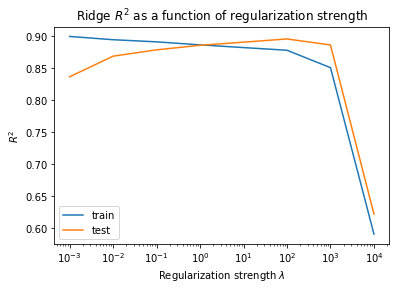

In [31]:
fig, ax = plt.subplots()
plt.xscale('log')
plt.title('Ridge $R^2$ as a function of regularization strength')
ax.set_xlabel('Regularization strength $\lambda$')
ax.set_ylabel('$R^2$')
ax.plot(alphas, train_scores, label='train')
ax.plot(alphas, test_scores, label='test')
plt.legend();

#### Observation

Notice how the values increase but then decrease? Regularization helps with overfitting, but if the strength of the regularization becomes too great, then large coefficients will be punished more than they really should. What happens then is that the original error between truth and model predictions becomes neglected as a quantity to be minimized, and the bias of the model begins to outweigh its variance.

It looks like the best value is somewhere around 100. If we wanted more precision, we could repeat the same sort of exercise with a set of alphas nearer to 100.

NOTE: We'll keep learning better tools to adjust these kinds of _hyperparameters_!

## Your Turn!

Run two models: both a Ridge and a LASSO regresssion model (without cross-validation) on the processed X data. Then, explore the coefficients. What do you notice?

You can use the default `alpha` parameter for both models. Use `random_state=42`

In [42]:
# Instantiate your Ridge regression
rr = Ridge(alpha=60, random_state=42)
# Fit
rr.fit(X_train_processed, y_train)
# Score on train
print('Train Score:', rr.score(X_train_processed, y_train))
# Score on test
print('Test Score:', rr.score(X_test_processed, y_test))


Train Score: 0.8795024410878567
Test Score: 0.8943705300987205


In [43]:
# Instantiate your LASSO regression
ls = Lasso(alpha=60, random_state=42)
# Fit
ls.fit(X_train_processed, y_train)
# Score on train
print('Train Score:',ls.score(X_train_processed, y_train))
# Score on test
print('Test Score:',ls.score(X_test_processed, y_test))

Train Score: 0.854244301408458
Test Score: 0.8778263815700327


In [44]:
# Explore LASSO coefficients
ls.coef_

array([  0.        ,   0.        ,  -0.        ,  61.21288134,
        -0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,  -0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
       152.16198797,  -0.        ,   0.        ,  -0.        ,
        -0.        ,   2.71105005,  -0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
       289.59736183,  -0.        ,  -0.        ,   0.        ,
         0.        ,  -0.        ,   0.        ,  -0.  

In [45]:
# Explore Ridge coefficients
rr.coef_

array([  0.        ,  17.14215486,  -3.18112111,  37.34289246,
        -1.35060478,  34.38172978,  -2.39806439,   1.89998807,
        20.34957197,  10.5124438 ,   9.52275407,  24.4538794 ,
        -4.26531434,  29.71183953,  -4.19845152,   0.29930223,
        12.48196732,  -2.29939819,  22.03455797,   0.29735955,
        32.96716321,  -0.61554308,   1.09385565,  17.81224527,
        35.50114251,   1.20767068,  32.47543944,  -0.66249681,
        -1.39051197,  19.10807513,  -1.35060478,   0.        ,
        -1.35060478,   0.        , -20.00904631,  34.38172978,
         0.        ,   0.        ,   0.26462132,  -2.39806439,
         0.        ,   5.88313057,   1.89998807,  -2.9985841 ,
        20.34957197,   3.67378687,   6.58703177,  14.95730644,
        -6.94959986,  24.18935154,  -6.49260415,  -1.15967623,
         4.14629536,   4.63773215,  20.84293303,  -2.47442105,
        27.45265004,  -2.49765351,  -0.48309583,  10.44363787,
        26.01648793,  -1.29158471,  27.39226459,  -1.94

#### Evaluate: What do you notice? Any observations?

- 


----

## LEVEL UP - Elastic Net!

Naturally, the Elastic Net has the same interface through sklearn as the other regularization tools! The only difference is that we now have to specify how much of each regularization term we want. The name of the parameter for this (represented by $\rho$ above) in sklearn is `l1_ratio`.

In [46]:
enet = ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

enet.fit(X_train_processed, y_train)

ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

In [47]:
enet.score(X_train_processed, y_train)

0.8126996671227142

In [48]:
enet.score(X_test_processed, y_test)

0.8521461762036051

Setting the `l1_ratio` to 1 is equivalent to the lasso:

In [49]:
ratios = np.linspace(0.01, 1, 100)

In [50]:
preds = []
for ratio in ratios:
    enet = ElasticNet(alpha=100, l1_ratio=ratio, random_state=42)
    enet.fit(X_train_processed, y_train)
    preds.append(enet.predict(X_test_processed[0].reshape(1, -1)))

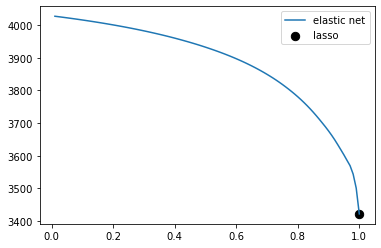

In [51]:
fig, ax = plt.subplots()

lasso = Lasso(alpha=100, random_state=42)
lasso.fit(X_train_processed, y_train)
lasso_pred = lasso.predict(X_test_processed[0].reshape(1, -1))

ax.plot(ratios, preds, label='elastic net')
ax.scatter(1, lasso_pred, c='k', s=70, label='lasso')
plt.legend();

#### Note on `ElasticNet()`

Is an Elastic Net with `l1_ratio` set to 0 equivalent to the ridge? In theory yes. But in practice no. It looks like the `ElasticNet()` predictions on the first test data point as `l1_ratio` shrinks are tending toward some value around 3400. Let's check to see what prediction `Ridge()` gives us:

In [52]:
ridge = Ridge(alpha=10, random_state=42)
ridge.fit(X_train_processed, y_train)
ridge.predict(X_test_processed[0].reshape(1, -1))[0]

3170.8108650422164

If you check the docstring for the `ElasticNet()` class you will see:
- that the function being minimized is slightly different from what we saw above; and
- that the results are unreliable when `l1_ratio` $\leq 0.01$.

**Exercise**: Visualize the difference in this case between `ElasticNet(l1_ratio=0.01)` and `Ridge()` by making a scatterplot of each model's predicted values for the first ten points in `X_test_processed`. Use `alpha=10` for each model.

        Level Up: Make a second scatterplot that compares the predictions on the same data
        points between ElasticNet(l1_ratio=1) and Lasso().

<details>
    <summary> Answer
    </summary>
    <code>fig, ax = plt.subplots()
enet_r = ElasticNet(alpha=10, l1_ratio=0.01, random_state=42)
enet_r.fit(X_train_processed, y_train)
preds_enr = enet_r.predict(X_test_processed[:10])
preds_ridge = ridge.predict(X_test_processed[:10])
ax.scatter(np.arange(10), preds_enr)
ax.scatter(np.arange(10), preds_ridge);</code>  
        </details>

<details>
    <summary>
        Level Up
    </summary>
<code>fig, ax = plt.subplots()
enet_l = ElasticNet(alpha=10, l1_ratio=1, random_state=42)
enet_l.fit(X_train_processed, y_train)
preds_enl = enet_l.predict(X_test_processed[:10])
preds_lasso = lasso.predict(X_test_processed[:10])
ax.scatter(np.arange(10), preds_enl)
ax.scatter(np.arange(10), preds_lasso);</code>
    </details

#### Fitting Regularized Models with Cross-Validation

Our friend `sklearn` also includes tools that fit regularized regressions *with cross-validation*: `LassoCV`, `RidgeCV`, and `ElasticNetCV`.

**Exercise**: Use `RidgeCV` to fit a seven-fold cross-validated ridge regression model to our `X_train_processed` data and then calculate $R^2$ and the RMSE (root-mean-squared error) on our test set.

<details>
    <summary>
        Answer
    </summary>
    <code>rcv = RidgeCV(cv=7)
rcv.fit(X_train_processed, y_train)
rcv.score(X_test_processed, y_test)
np.sqrt(mean_squared_error(y_test, rcv.predict(X_test_processed)))</code>
    </details>